In [1]:
%load_ext yamlmagic

In [2]:
import numpy as np
import os
import matplotlib.pyplot as plt
from matplotlib import colormaps as cm
from matplotlib.colors import ListedColormap
from matplotlib import patches
from PIL import Image
import pandas as pd

In [16]:
file_path = r'C:\Users\yaesu539\OneDrive - Uppsala universitet\PhD\DATA\Fluorescence microscope\220223\Channel 1'
save_path = r'C:\Users\yaesu539\OneDrive - Uppsala universitet\PhD\DATA\Fluorescence microscope\220223\Channel 1'
conc = 0.5 #mg/mL of FITC D10S
font_size = 12
save_status = "" #"save" to save the PNG files
reference = 0 #"No" if no reference shall be taken, otherwise, index
title_graph = ""

In [17]:
default_line_start = [1170, 1170]
default_line_end = [300, 700]

def get_files(file_path):
    filename_paths = [os.path.join(file_path,f) for f in sorted(os.listdir(file_path)) if f.endswith(".png")]
    filename =  [str(f) for f in sorted(os.listdir(file_path)) if f.endswith(".png")]
    return filename_paths, filename

files = get_files(file_path)

# prefill options for images
s = """%%yaml conf

files:
"""
for fp, fn in zip(*files):
    s+=f"""
  - filename: r"{fn}"
    filepath: r"{fp}"
    line_pos_x: {default_line_start}  
    line_pos_y: {default_line_end} # [y_min, y_max]
"""

get_ipython().set_next_input(s)

In [18]:
%%yaml conf

files:

  - filename: r"150_1.png"
    filepath: r"C:\Users\yaesu539\OneDrive - Uppsala universitet\PhD\DATA\Fluorescence microscope\220223\Channel 1\150_1.png"
    line_pos_x: [1170, 1170]  
    line_pos_y: [300, 700] # [y_min, y_max]

  - filename: r"150_3.png"
    filepath: r"C:\Users\yaesu539\OneDrive - Uppsala universitet\PhD\DATA\Fluorescence microscope\220223\Channel 1\150_3.png"
    line_pos_x: [1170, 1170]  
    line_pos_y: [300, 700] # [y_min, y_max]

  - filename: r"40_1.png"
    filepath: r"C:\Users\yaesu539\OneDrive - Uppsala universitet\PhD\DATA\Fluorescence microscope\220223\Channel 1\40_1.png"
    line_pos_x: [1170, 1170]  
    line_pos_y: [300, 700] # [y_min, y_max]

  - filename: r"40_6.png"
    filepath: r"C:\Users\yaesu539\OneDrive - Uppsala universitet\PhD\DATA\Fluorescence microscope\220223\Channel 1\40_6.png"
    line_pos_x: [1170, 1170]  
    line_pos_y: [300, 700] # [y_min, y_max]

  - filename: r"80_1.png"
    filepath: r"C:\Users\yaesu539\OneDrive - Uppsala universitet\PhD\DATA\Fluorescence microscope\220223\Channel 1\80_1.png"
    line_pos_x: [1170, 1170]  
    line_pos_y: [300, 700] # [y_min, y_max]

  - filename: r"80_3.png"
    filepath: r"C:\Users\yaesu539\OneDrive - Uppsala universitet\PhD\DATA\Fluorescence microscope\220223\Channel 1\80_3.png"
    line_pos_x: [1170, 1170]  
    line_pos_y: [300, 700] # [y_min, y_max]


<IPython.core.display.Javascript object>

In [19]:
conf = conf
conf['files'][0]['line_pos_y'][0]

300

In [22]:
def get_conc_maps(file_path, conc, font_size, save_status, ref, conf):
    filename_path, filename = get_files(file_path)
    if ref != "No":
        base_file = filename_path[ref]
        pixel_basefile_G = get_pixels_RGB(base_file)
        max_pixelbf_G = np.max(pixel_basefile_G)
        k = conc/max_pixelbf_G
    if ref == "No":
        k = conc
    for fp, f in zip(filename_path, filename):
        pixel_conc = plot_surface(fp, k, f, font_size, save_status)
        i = filename_path.index(fp)
        line_conc = get_line_conc(i, conf, pixel_conc)
        conf['files'][i]['line_conc'] = line_conc
    plot_line_conc(conf)
    plot_line_conc_norm(conf)

def get_pixels_RGB(file):
    im = Image.open(file, 'r')
    pixel_RGB = np.array(im)
    pixel_G = np.float32(pixel_RGB[:,:,1])
    return (pixel_G)

def get_pixels_conc(pixel_G, k):
    max_pixel_G = np.max(pixel_G)
    if reference != "No":
        pixel_conc = (pixel_G * k)
    if reference == "No":
        pixel_conc = (pixel_G * k)/max_pixel_G
    return pixel_conc

def plot_surface(file, k, title, font_size, save_status):
    pixel_G = get_pixels_RGB(file)
    pixel_conc = get_pixels_conc(pixel_G, k)
    plt.figure(figsize=(6,6))
    cmap = cm['jet']
    newcolors = cmap(np.linspace(0, 1, 256))
    black = np.array([0, 0, 0, 1])
    newcolors[:12, :] = black
    newcmp = ListedColormap(newcolors)
    plt.imshow(pixel_conc, cmap = 'jet', vmax=2, vmin=0)
    plt.colorbar().set_label(label="FITC concentration [mg/mL]", size=font_size)
    #title = title.replace("40 uL ", "")
    title =  " " + title[:-4]
    plot_format(title_graph + title, font_size, save_status)
    return pixel_conc

def get_line_conc(i, conf, pixel_conc):
    xs = conf['files'][i]['line_pos_x']   
    ys = conf['files'][i]['line_pos_y']
    plt.plot((xs[0], xs[0]), ys, color="fuchsia")
    plt.show()
    line_conc = pixel_conc[min(ys): max(ys), xs[0]]
    assert len(line_conc) > 0
    return line_conc

def plot_line_conc(conf):
    ratios = []
    for i, l in enumerate(conf['files']):
        c = l['line_conc']
        label = l['filename'].replace("80 uL ", "")
        label = label[2:-8]
        plt.plot(np.arange(len(c)), c, label=label)
        ratio = get_mixing_efficiency(c)
        ratio_perc = format(ratio * 100, '.1f') + '%'
        conf['files'][i]['Mixing'] = ratio_perc
        conf['files'][i]['ROI'] = label
    df = get_df(conf)
    display(df[['ROI', 'Mixing']])
    plt.xlabel("FITC concentration [mg/mL]")
    plt.ylabel("Position [pixel]")
    plt.title(title_graph)
    plt.legend(title="ROI")
    plt.show()

def plot_line_conc_norm(conf):
    ratios = []
    for i, l in enumerate(conf['files']):
        c = l['line_conc']
        label = l['filename'].replace("80 uL ", "")
        label = label[2:-8]
        plt.plot(np.arange(len(c)), c/conc, label=label)
        ratio = get_mixing_efficiency(c)
        ratio_perc = format(ratio * 100, '.1f') + '%'
        conf['files'][i]['Mixing'] = ratio_perc
        conf['files'][i]['ROI'] = label
    df = get_df(conf)
    display(df[['ROI', 'Mixing']])
    plt.ylabel("C/C$_0$")
    plt.xlabel("Y/Y$_0$")
    plt.title(title_graph)
    plt.legend(title="ROI")
    plt.show()

def get_df(conf):
    return pd.DataFrame(x for x in conf['files'])

def get_mixing_efficiency(c):
    averaged_pixels = 100
    half = int(averaged_pixels/2)
    c = c[50:-50]
    n = len(c)
    if n >= 2*averaged_pixels:
        first = c[:half]
        last = c[-half:]
        avg_first = sum(first) / len(first)
        avg_last = sum(last) / len(last)
        ratio = avg_first / avg_last
    else:
        print("Array does not contain at least 100 elements")
    return ratio

def plot_format(title, font_size, save_status):
    plt.title(title, size=font_size+2)
    plt.axis("off")
    if save_status == "save":
        plt.savefig(os.path.join(save_path, f"{title}.svg"), transparent=True)
    


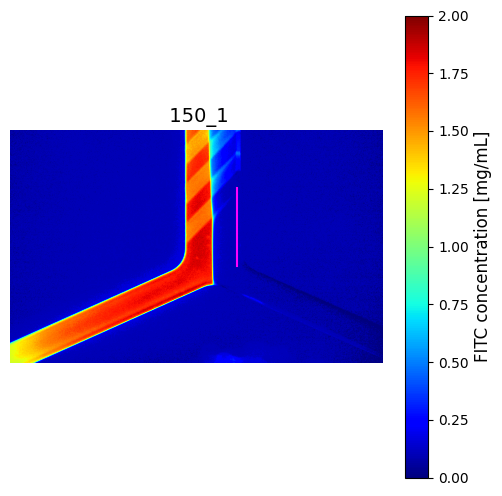

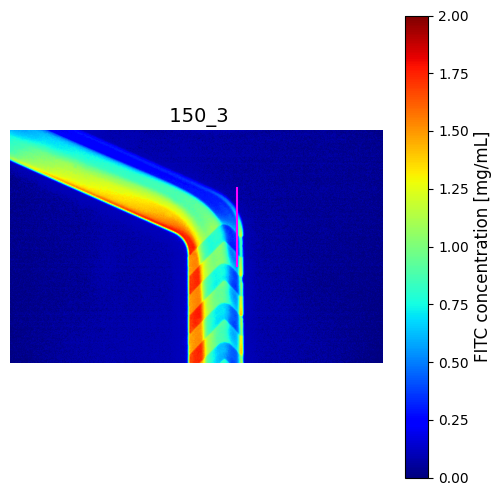

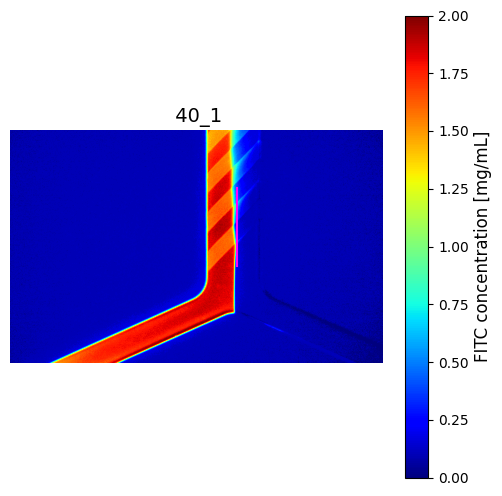

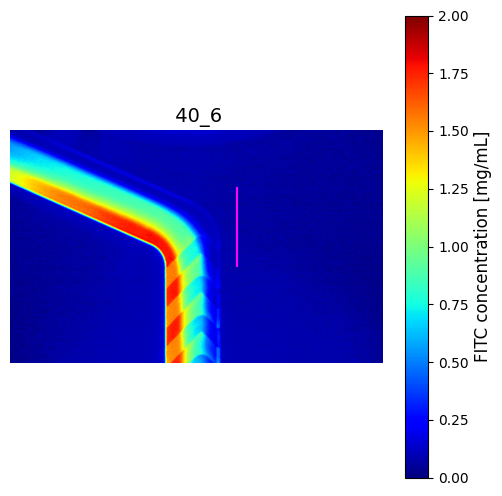

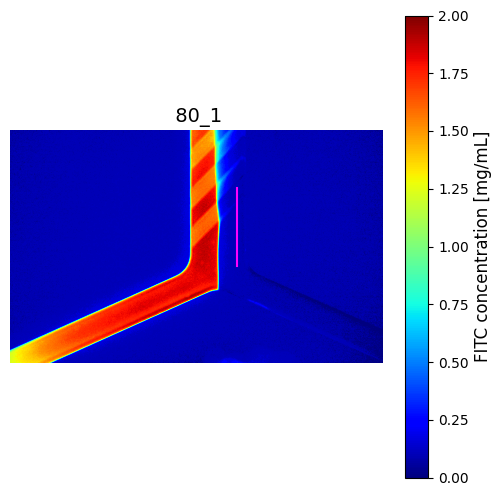

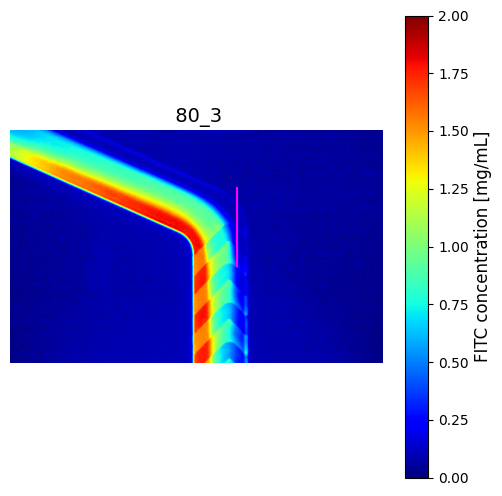

,ROI,Mixing
0,15,95.7%
1,15,20.2%
2,4,325.4%
3,4,45.9%
4,8,105.7%
5,8,48.3%


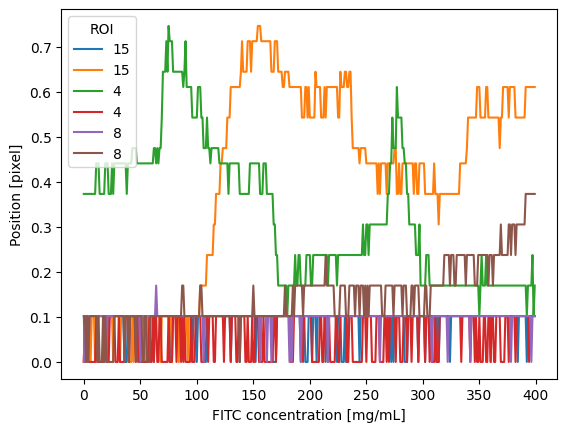

,ROI,Mixing
0,15,95.7%
1,15,20.2%
2,4,325.4%
3,4,45.9%
4,8,105.7%
5,8,48.3%


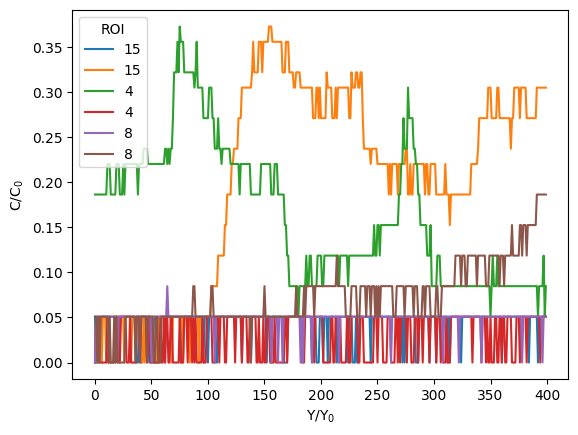

In [23]:
get_conc_maps(file_path, conc, font_size, save_status, reference, conf)


In [9]:

def conc_profile_plot(conc_profile):
    colors = ["royalblue", "firebrick"]
    for i, (c, co) in enumerate(zip(conc_profile, colors)):
        position = np.arange(len(c))
        if i == 0:
            position = position - 14
        plt.plot(position, c, color=co)
        plt.xlim(250,900)
        plt.xticks(fontsize=22)
        plt.yticks(fontsize=22)
    #plt.savefig(os.path.join(save_path, "conc_profile.svg"))
    plt.show()